# Grupo:

#### Alessandro de Freitas Guerreiro - 11233891
#### Matheus Yasuo Ribeiro Utino - 11233689
#### Vinícius Silva Montanari - 11233709

## Tema: Classificação por imagens da patologia retinopatia diabética utilizando técnicas de aprendizado de máquina
### Universidade de São Paulo
### Instituto de Ciências Matemáticas e de Computação (ICMC)
### SCC0276 - Aprendizado de Máquina (2022)

In [1]:
# Standard dependencies
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
import keras
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

# Data Analysis

In [2]:
#Define path of files

KAGGLE_DIR = '../input/aptos2019-blindness-detection/'
TRAIN_DF_PATH = KAGGLE_DIR + "train.csv"
TRAIN_IMG_PATH = KAGGLE_DIR + "train_images/"

In [3]:
#Load csv and convert to pandas dataframe

df = pd.read_csv(TRAIN_DF_PATH)
df['id_code'] = df['id_code'] + ".png"

In [4]:
#Show dataset shape and informations

print("Train dataset size :", df.shape, "\n")
df.head()

Train dataset size : (3662, 2) 



,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [5]:
#Get number of occurrences of each class in train dataset

df.groupby('diagnosis').count()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


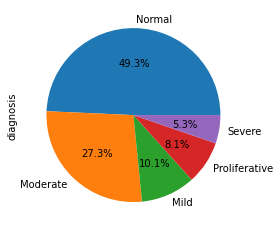

In [6]:
#Pie graph for classes in train dataset

df['diagnosis'].value_counts().plot(labels = ['Normal', 'Moderate', 'Mild', 'Proliferative', 'Severe'],kind = 'pie',autopct='%1.1f%%')
plt.savefig('pie_train_classes.png', dpi = 400)
plt.show() 

In [7]:
# Remove duplicated lines in dataframes
df = df.drop_duplicates()
print("Dataset size :", df.shape, "\n")

# Analysis Nan values in dataframes
print("There are Nan in dataset? ", bool(df.isnull().sum().sum()), "\n")

Dataset size : (3662, 2) 

There are Nan in dataset?  False 



Shape of Image: (1050, 1050, 3)
Shape of Image: (1736, 2416, 3)
Shape of Image: (2136, 3216, 3)
Shape of Image: (1958, 2588, 3)
Shape of Image: (2136, 3216, 3)


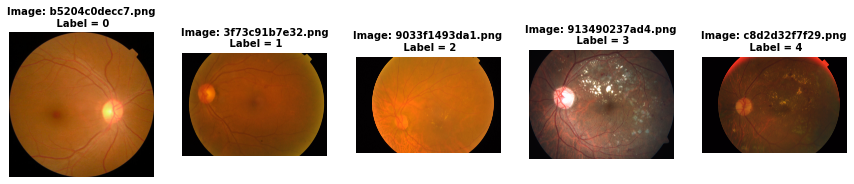

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plot one figure for each class in dataframe

fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = df[df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = mpimg.imread('../input/aptos2019-blindness-detection/train_images/' + image_name)
    print("Shape of Image: " + str(X.shape))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);
plt.savefig('real_images.png', dpi = 200)

# Preprocessing

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import *
from keras.models import Sequential, load_model
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam 
import tensorflow.keras as keras
from tensorflow.keras.applications import EfficientNetB3

#Define some constants about the images

IMG_WIDTH = 320
IMG_HEIGHT = 320
NUM_DIMENSIONS = 3
BATCH_SIZE = 1

INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, NUM_DIMENSIONS)

#Building a cnn for features extraction using fine tunning

efnb3 = EfficientNetB3(weights='imagenet', include_top = False, input_shape = INPUT_SHAPE)

model = Sequential()
model.add(efnb3)
model.add(GlobalAveragePooling2D())

model.summary()


2022-07-03 16:23:00.490910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 16:23:00.609822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 16:23:00.610922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 16:23:00.613003: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

43950080/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
Total params: 10,783,535
Trainable params: 10,696,232
Non-trainable params: 87,303
_________________________________________________________________


In [10]:
def generator(IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE):

    # Image Data Generator

    train_datagen = ImageDataGenerator()

    # Resize and load image

    train_generator = train_datagen.flow_from_dataframe(df, 
                                                        x_col = 'id_code', 
                                                        y_col = 'diagnosis',
                                                        directory = TRAIN_IMG_PATH,
                                                        target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                        batch_size = BATCH_SIZE,
                                                        seed = 42,
                                                        class_mode = 'raw', 
                                                        subset = 'training')
    
    return train_generator

In [11]:
# Generate data

def generateData(generator, numElements, isFineTuning):
    x = []
    y = []
        
    for j in tqdm(range(0, numElements)):
        img, label = next(generator)
        if(isFineTuning == True):
            x.append(model.predict(img))
        else:
            x.append(img)
        y.append(label)
            
    if(isFineTuning == True):
        return np.array(x),np.array(y)
    return np.array(x, dtype = np.uint8),np.array(y, dtype = np.uint8)

In [12]:
train_generator = generator(IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE)

Found 3662 validated image filenames.


In [13]:
print('Generating dataset!')
x_train, y_train = generateData(train_generator, len(train_generator), True)

Generating dataset!


  0%|          | 0/3662 [00:00<?, ?it/s]2022-07-03 16:23:17.783845: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-03 16:23:20.996317: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 3662/3662 [15:53<00:00,  3.84it/s]


In [14]:
x_train.shape

(3662, 1, 1536)

In [15]:
y_train.shape

(3662, 1)

In [16]:
def changeDimension(x, y):

    #Change dimension (numElements, 1, IMG_WIDTH, IMG_HEIGHT, NUM_DIMENSIONS) to (numElements, IMG_WIDTH, IMG_HEIGHT, NUM_DIMENSIONS)
    x = np.array(np.squeeze(x, axis = 1))

    #Change dimension (numElements, 1) to (numElements)
    y = np.ravel(y)
    
    return x, y

In [17]:
x_train, y_train = changeDimension(x_train, y_train)

In [18]:
IMG_WIDTH_B4 = 380
IMG_HEIGHT_B4 = 380

INPUT_SHAPE_B4 = (IMG_WIDTH_B4, IMG_HEIGHT_B4, NUM_DIMENSIONS)

train_generator_B4 = generator(IMG_WIDTH_B4, IMG_HEIGHT_B4, BATCH_SIZE)

Found 3662 validated image filenames.


In [19]:
print('Generating dataset for EfficientNet-B4!')
x_train_B4, y_train_B4 = generateData(train_generator_B4, len(train_generator_B4), False)

Generating dataset for EfficientNet-B4!


100%|██████████| 3662/3662 [10:39<00:00,  5.72it/s]


In [20]:
x_train_B4, y_train_B4 = changeDimension(x_train_B4, y_train_B4)

In [21]:
from sklearn.model_selection import train_test_split

#Generate train, validate and test 

def getDatasets(x_train, y_train):

    x_train_2, x_test, y_train_2, y_test = train_test_split(x_train, y_train, test_size = 0.15, stratify = y_train, shuffle = True, random_state = 42)

    x_train_final, x_val, y_train_final, y_val = train_test_split(x_train_2, y_train_2, test_size = 0.2, stratify = y_train_2, shuffle = True, random_state = 42)
    
    return x_train_final, y_train_final, x_val, y_val, x_test, y_test

In [22]:
x_train, y_train, x_val, y_val, x_test, y_test = getDatasets(x_train, y_train)
x_train_B4, y_train_B4, x_val_B4, y_val_B4, x_test_B4, y_test_B4 = getDatasets(x_train_B4, y_train_B4)

In [23]:
import gc

del df
del efnb3
del model
del train_generator
del train_generator_B4

gc.collect()

124236

In [24]:
from imblearn.over_sampling import SMOTE

# Using Synthetic Minority Oversampling Technique (SMOTE) to balance dataset

sm = SMOTE(random_state = 42)

x_train_SMOTE, y_train_SMOTE = sm.fit_resample(x_train, y_train)

In [25]:
from imblearn.over_sampling import RandomOverSampler 

# Using RandomOverSampler to balance dataset

sm = RandomOverSampler(random_state = 42)

x_train_ROV, y_train_ROV = sm.fit_resample(x_train, y_train)

In [26]:
from imblearn.over_sampling import BorderlineSMOTE

# Using BorderlineSMOTE to balance dataset

sm = BorderlineSMOTE(random_state = 42)

x_train_BLM, y_train_BLM = sm.fit_resample(x_train, y_train)

In [27]:
from imblearn.over_sampling import ADASYN 

# Using ADASYN  to balance dataset

sm = ADASYN(random_state = 42)

x_train_ADASYN, y_train_ADASYN = sm.fit_resample(x_train, y_train)

In [28]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AlphaDropout

#Using transfer learning in EfficientNetB4

efnb4 = EfficientNetB4(weights='imagenet', include_top = False, input_shape = INPUT_SHAPE_B4)

#Freeze original layers
for layer in efnb4.layers: 
  layer.trainable = False

#Remove last layer and add new layers
last_layer = efnb4.layers[-1].output
x = GlobalAveragePooling2D()(last_layer)
x = Dense(1000, activation='relu', name = 'fc1')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
x = Dense(500, activation='relu', name = 'fc2')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
x = Dense(100, activation='relu', name = 'fc3')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
x = Dense(5, activation = 'softmax', name = 'predictions')(x)

#Define new model
model_B4 = Model(inputs = efnb4.inputs, outputs = x)
model_B4.compile(optimizer = Adam(learning_rate = 5e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])


#Save best model and using early stopping
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_B4',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
]


71696384/71686520 [==============================] - 2s 0us/step


In [29]:
#Ordinal for one hot enconder

def oneHotEnconder(vector):
    targets = vector.reshape(-1)
    one_hot_targets = np.eye(5)[targets]
    
    return one_hot_targets

# Results

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tensorflow.keras.models import load_model

#Get results of validate and test dataset

def getResults(nameClassifier, nameDataAugmentation, x_train, y_train, x_val, y_val, x_test, y_test):
    
    print("Using ", nameClassifier, "and", nameDataAugmentation, "data augmentation technic\n\n")
    
    results_val = []
    
    batch_size = 32
    epochs = 120
    
    if(nameClassifier == "KNN"):
        for K in range(2, 13):
            for weight in ['uniform','distance']:
                clf = KNeighborsClassifier(n_neighbors = K, weights = weight)
                clf.fit(x_train, y_train)
                y_pred = clf.predict(x_val)
                results_val.append([K, weight, accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='macro'), cohen_kappa_score(y_val, y_pred, weights = 'quadratic')])
                
    elif(nameClassifier == "Decision Tree"):
        for max_depth in range(2, 7):
            for criterion in ['gini', 'entropy']:
                clf = DecisionTreeClassifier(max_depth = max_depth, criterion = criterion, random_state = 42)
                clf.fit(x_train, y_train)
                y_pred = clf.predict(x_val)
                results_val.append([max_depth, criterion, accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='macro'), cohen_kappa_score(y_val, y_pred, weights = 'quadratic')])
    
    elif(nameClassifier == "SVM"): 
        for C in [10, 100, 1000]:
            for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
                clf = svm.SVC(C = C, kernel = kernel, random_state = 42)
                clf.fit(x_train, y_train)
                y_pred = clf.predict(x_val)
                results_val.append([C, kernel, accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='macro'), cohen_kappa_score(y_val, y_pred, weights = 'quadratic')])
    elif(nameClassifier == "CNN"):
        model_B4.fit(x_train, y_train, batch_size = batch_size, validation_data = (x_val, y_val), callbacks = callbacks_list, epochs = epochs)
        # Load the best saved model
        model = load_model('model_B4')
        y_pred = model.predict(x_val)
        results_val.append([batch_size, epochs, accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1)), f1_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1), average='macro'), cohen_kappa_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1), weights = 'quadratic')])
    
    
    print("Results of validate:\n")
    for i in results_val:
        print(i)
    print("\n")
    
    
    max = results_val[0][4]
    index_max = 0
    # Search max cohen kappa score
    for i in range(1,len(results_val)):
        if(results_val[i][4] > max):
            max = results_val[i][4]
            index_max = i
    
    print("Best validate results and params:",results_val[index_max])
    
    results_test = []
    
    if(nameClassifier == "KNN"):
        clf = KNeighborsClassifier(n_neighbors = results_val[index_max][0], weights = results_val[index_max][1])
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        results_test.append([results_val[index_max][0], results_val[index_max][1], accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), cohen_kappa_score(y_test, y_pred, weights = 'quadratic')])
        
    elif(nameClassifier == "Decision Tree"):
        clf = DecisionTreeClassifier(max_depth = results_val[index_max][0], criterion = results_val[index_max][1], random_state = 42)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        results_test.append([results_val[index_max][0], results_val[index_max][1], accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), cohen_kappa_score(y_test, y_pred, weights = 'quadratic')])
        
    elif(nameClassifier == "SVM"): 
        clf = svm.SVC(C = results_val[index_max][0], kernel = results_val[index_max][1], random_state = 42)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        results_test.append([results_val[index_max][0], results_val[index_max][1], accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), cohen_kappa_score(y_test, y_pred, weights = 'quadratic')]) 
    elif(nameClassifier == "CNN"):
        y_pred = model.predict(x_test)
        results_test.append([results_val[index_max][0], results_val[index_max][1], accuracy_score(y_test, np.argmax(y_pred, axis=1)), f1_score(y_test, np.argmax(y_pred, axis=1), average='macro'), cohen_kappa_score(y_test, np.argmax(y_pred, axis=1), weights = 'quadratic')]) 
    
    print("Result of test:",results_test)
    print("\n\n\n")

## K-Nearest Neighbors (KNN)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

getResults("KNN", "Nothing", x_train, y_train, x_val, y_val, x_test, y_test)
getResults("KNN", "Synthetic Minority Oversampling Technique (SMOTE)",  x_train_SMOTE, y_train_SMOTE, x_val, y_val, x_test, y_test)
getResults("KNN", "RandomOverSampler", x_train_ROV, y_train_ROV, x_val, y_val, x_test, y_test)
getResults("KNN", "BorderlineSMOTE",  x_train_BLM, y_train_BLM, x_val, y_val, x_test, y_test)
getResults("KNN", "ADASYN", x_train_ADASYN, y_train_ADASYN, x_val, y_val, x_test, y_test)

Using  KNN and Nothing data augmentation technic


Results of validate:

[2, 'uniform', 0.7271268057784912, 0.4417260617853612, 0.7435418772784363]
[2, 'distance', 0.7415730337078652, 0.5384159270593273, 0.7693173571100612]
[3, 'uniform', 0.7431781701444623, 0.46580915488805025, 0.7463616171826819]
[3, 'distance', 0.7560192616372392, 0.5218734399701372, 0.7904541402092862]
[4, 'uniform', 0.7592295345104334, 0.4912971999422928, 0.7845262296137536]
[4, 'distance', 0.7608346709470305, 0.5101089532057023, 0.8022347787442068]
[5, 'uniform', 0.7624398073836276, 0.47242692410921894, 0.7731674316433077]
[5, 'distance', 0.7688603531300161, 0.5115215719611583, 0.8036787876642]
[6, 'uniform', 0.7656500802568218, 0.4793307347900523, 0.7832139442909338]
[6, 'distance', 0.7704654895666132, 0.5093206614553132, 0.7963111575864184]
[7, 'uniform', 0.7640449438202247, 0.45829664937264036, 0.7885528440729676]
[7, 'distance', 0.7720706260032103, 0.496457471441803, 0.8151627833379484]
[8, 'uniform', 0.77367

# Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

getResults("Decision Tree", "Nothing", x_train, y_train, x_val, y_val, x_test, y_test)
getResults("Decision Tree", "Synthetic Minority Oversampling Technique (SMOTE)", x_train_SMOTE, y_train_SMOTE, x_val, y_val, x_test, y_test)
getResults("Decision Tree", "RandomOverSampler", x_train_ROV, y_train_ROV, x_val, y_val, x_test, y_test)
getResults("Decision Tree", "BorderlineSMOTE", x_train_BLM, y_train_BLM, x_val, y_val, x_test, y_test)
getResults("Decision Tree", "ADASYN", x_train_ADASYN, y_train_ADASYN, x_val, y_val, x_test, y_test)

Using  Decision Tree and Nothing data augmentation technic


Results of validate:

[2, 'gini', 0.6886035313001605, 0.29884751392289083, 0.598690089660719]
[2, 'entropy', 0.666131621187801, 0.3070299894284602, 0.635505816875314]
[3, 'gini', 0.7191011235955056, 0.3647509300058491, 0.7277074257927261]
[3, 'entropy', 0.7126805778491172, 0.31590713208360266, 0.7388398131140295]
[4, 'gini', 0.723916532905297, 0.37901475226130477, 0.7598584175754937]
[4, 'entropy', 0.7142857142857143, 0.37395560635087555, 0.74316533155997]
[5, 'gini', 0.7303370786516854, 0.4138827585643418, 0.7645447716276053]
[5, 'entropy', 0.7255216693418941, 0.4539123638270489, 0.7679669437749028]
[6, 'gini', 0.7271268057784912, 0.4667470325756827, 0.7486628660822505]
[6, 'entropy', 0.6966292134831461, 0.44320362383562084, 0.7312566481813939]


Best validate results and params: [5, 'entropy', 0.7255216693418941, 0.4539123638270489, 0.7679669437749028]
Result of test: [[5, 'entropy', 0.7127272727272728, 0.40922295488586524,

## Support Vector Machines (SVM)

In [33]:
from sklearn import svm

getResults("SVM", "Nothing", x_train, y_train, x_val, y_val, x_test, y_test)
getResults("SVM", "Synthetic Minority Oversampling Technique (SMOTE)",  x_train_SMOTE, y_train_SMOTE, x_val, y_val, x_test, y_test)
getResults("SVM", "RandomOverSampler", x_train_ROV, y_train_ROV, x_val, y_val, x_test, y_test)
getResults("SVM", "BorderlineSMOTE",  x_train_BLM, y_train_BLM, x_val, y_val, x_test, y_test)
getResults("SVM", "ADASYN", x_train_ADASYN, y_train_ADASYN, x_val, y_val, x_test, y_test)

Using  SVM and Nothing data augmentation technic


Results of validate:

[10, 'linear', 0.797752808988764, 0.6133721376915101, 0.8721977549986858]
[10, 'poly', 0.8218298555377207, 0.6326302773850545, 0.880552182527002]
[10, 'rbf', 0.8298555377207063, 0.6462966826650732, 0.8888822522695164]
[10, 'sigmoid', 0.7640449438202247, 0.5232992603673232, 0.8265153637416534]
[100, 'linear', 0.7913322632423756, 0.5947637740861388, 0.8635410058425639]
[100, 'poly', 0.8138041733547352, 0.6291580935216347, 0.8870104086648326]
[100, 'rbf', 0.8218298555377207, 0.6499814040330121, 0.8844698779924924]
[100, 'sigmoid', 0.7415730337078652, 0.5379288428589899, 0.7960076139694219]
[1000, 'linear', 0.797752808988764, 0.6015285536630847, 0.8564713123105265]
[1000, 'poly', 0.8057784911717496, 0.61139051090243, 0.8747685266851708]
[1000, 'rbf', 0.8234349919743178, 0.6495695090664, 0.8829165527978091]
[1000, 'sigmoid', 0.7223113964686998, 0.514185966559895, 0.7913669377636672]


Best validate results and params: 

## Convolution Neural Network (CNN) - EfficientNet-B4

In [34]:
# Free memory

del x_train
del y_train
del x_val
del y_val
del x_test
del y_test
del x_train_SMOTE
del y_train_SMOTE
del x_train_ROV
del y_train_ROV
del x_train_BLM
del y_train_BLM
del x_train_ADASYN
del y_train_ADASYN
gc.collect()

1166

In [35]:
from sklearn.preprocessing import OneHotEncoder

getResults("CNN", "Nothing", x_train_B4, oneHotEnconder(y_train_B4), x_val_B4, oneHotEnconder(y_val_B4), x_test_B4, y_test_B4)

Using  CNN and Nothing data augmentation technic




2022-07-03 17:05:52.559559: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1078234800 exceeds 10% of free system memory.
2022-07-03 17:05:53.687010: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1078234800 exceeds 10% of free system memory.


Epoch 1/120
78/78 [==============================] - 42s 367ms/step - loss: 1.1242 - accuracy: 0.5886 - val_loss: 0.7221 - val_accuracy: 0.7352

Epoch 00001: val_loss improved from inf to 0.72211, saving model to model_B4


2022-07-03 17:07:04.158390: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/120
78/78 [==============================] - 23s 301ms/step - loss: 0.7936 - accuracy: 0.7196 - val_loss: 0.6231 - val_accuracy: 0.7640

Epoch 00002: val_loss improved from 0.72211 to 0.62314, saving model to model_B4


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/120
78/78 [==============================] - 23s 300ms/step - loss: 0.7472 - accuracy: 0.7220 - val_loss: 0.5915 - val_accuracy: 0.7673

Epoch 00003: val_loss improved from 0.62314 to 0.59155, saving model to model_B4


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/120
78/78 [==============================] - 23s 300ms/step - loss: 0.7305 - accuracy: 0.7252 - val_loss: 0.6999 - val_accuracy: 0.7464

Epoch 00004: val_loss did not improve from 0.59155
Epoch 5/120
78/78 [==============================] - 23s 299ms/step - loss: 0.7099 - accuracy: 0.7360 - val_loss: 0.6025 - val_accuracy: 0.7785

Epoch 00005: val_loss did not improve from 0.59155
Epoch 6/120
78/78 [==============================] - 23s 301ms/step - loss: 0.6614 - accuracy: 0.7429 - val_loss: 0.5975 - val_accuracy: 0.7737

Epoch 00006: val_loss did not improve from 0.59155
Epoch 7/120
78/78 [==============================] - 23s 301ms/step - loss: 0.6643 - accuracy: 0.7380 - val_loss: 0.5603 - val_accuracy: 0.7945

Epoch 00007: val_loss improved from 0.59155 to 0.56034, saving model to model_B4


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/120
78/78 [==============================] - 23s 300ms/step - loss: 0.6355 - accuracy: 0.7557 - val_loss: 0.5459 - val_accuracy: 0.7994

Epoch 00008: val_loss improved from 0.56034 to 0.54586, saving model to model_B4


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/120
78/78 [==============================] - 23s 300ms/step - loss: 0.6446 - accuracy: 0.7605 - val_loss: 0.5551 - val_accuracy: 0.8138

Epoch 00009: val_loss did not improve from 0.54586
Epoch 10/120
78/78 [==============================] - 23s 300ms/step - loss: 0.6275 - accuracy: 0.7642 - val_loss: 0.5485 - val_accuracy: 0.8026

Epoch 00010: val_loss did not improve from 0.54586
Epoch 11/120
78/78 [==============================] - 23s 299ms/step - loss: 0.6344 - accuracy: 0.7642 - val_loss: 0.5644 - val_accuracy: 0.7865

Epoch 00011: val_loss did not improve from 0.54586
Epoch 12/120
78/78 [==============================] - 23s 300ms/step - loss: 0.6092 - accuracy: 0.7698 - val_loss: 0.5358 - val_accuracy: 0.7994

Epoch 00012: val_loss improved from 0.54586 to 0.53583, saving model to model_B4


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/120
78/78 [==============================] - 23s 299ms/step - loss: 0.5987 - accuracy: 0.7770 - val_loss: 0.5187 - val_accuracy: 0.8058

Epoch 00013: val_loss improved from 0.53583 to 0.51866, saving model to model_B4


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/120
78/78 [==============================] - 24s 308ms/step - loss: 0.5722 - accuracy: 0.7851 - val_loss: 0.5410 - val_accuracy: 0.7978

Epoch 00014: val_loss did not improve from 0.51866
Epoch 15/120
78/78 [==============================] - 23s 300ms/step - loss: 0.6075 - accuracy: 0.7802 - val_loss: 0.5060 - val_accuracy: 0.8090

Epoch 00015: val_loss improved from 0.51866 to 0.50597, saving model to model_B4


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/120
78/78 [==============================] - 23s 300ms/step - loss: 0.5823 - accuracy: 0.7754 - val_loss: 0.4973 - val_accuracy: 0.8122

Epoch 00016: val_loss improved from 0.50597 to 0.49728, saving model to model_B4


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/120
78/78 [==============================] - 23s 300ms/step - loss: 0.5731 - accuracy: 0.7838 - val_loss: 0.5278 - val_accuracy: 0.7913

Epoch 00017: val_loss did not improve from 0.49728
Epoch 18/120
78/78 [==============================] - 23s 300ms/step - loss: 0.5639 - accuracy: 0.7875 - val_loss: 0.5019 - val_accuracy: 0.8090

Epoch 00018: val_loss did not improve from 0.49728
Epoch 19/120
78/78 [==============================] - 23s 300ms/step - loss: 0.5739 - accuracy: 0.7843 - val_loss: 0.5044 - val_accuracy: 0.8106

Epoch 00019: val_loss did not improve from 0.49728
Epoch 20/120
78/78 [==============================] - 23s 299ms/step - loss: 0.5614 - accuracy: 0.7931 - val_loss: 0.5040 - val_accuracy: 0.8074

Epoch 00020: val_loss did not improve from 0.49728
Epoch 21/120
78/78 [==============================] - 24s 309ms/step - loss: 0.5477 - accuracy: 0.7951 - val_loss: 0.4997 - val_accuracy: 0.8122

Epoch 00021: val_loss did not improve from 0.49728
Epoch 22/120
78

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/120
78/78 [==============================] - 23s 301ms/step - loss: 0.5351 - accuracy: 0.8051 - val_loss: 0.5004 - val_accuracy: 0.8138

Epoch 00023: val_loss did not improve from 0.48969
Epoch 24/120
78/78 [==============================] - 23s 302ms/step - loss: 0.5289 - accuracy: 0.8055 - val_loss: 0.4882 - val_accuracy: 0.8170

Epoch 00024: val_loss improved from 0.48969 to 0.48821, saving model to model_B4


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/120
78/78 [==============================] - 23s 300ms/step - loss: 0.5401 - accuracy: 0.8007 - val_loss: 0.4944 - val_accuracy: 0.8154

Epoch 00025: val_loss did not improve from 0.48821
Epoch 26/120
78/78 [==============================] - 23s 302ms/step - loss: 0.5332 - accuracy: 0.8023 - val_loss: 0.4740 - val_accuracy: 0.8074

Epoch 00026: val_loss improved from 0.48821 to 0.47396, saving model to model_B4


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/120
78/78 [==============================] - 23s 301ms/step - loss: 0.5231 - accuracy: 0.8128 - val_loss: 0.4841 - val_accuracy: 0.8154

Epoch 00027: val_loss did not improve from 0.47396
Epoch 28/120
78/78 [==============================] - 23s 301ms/step - loss: 0.5214 - accuracy: 0.8023 - val_loss: 0.4975 - val_accuracy: 0.8170

Epoch 00028: val_loss did not improve from 0.47396
Epoch 29/120
78/78 [==============================] - 24s 309ms/step - loss: 0.4941 - accuracy: 0.8136 - val_loss: 0.5328 - val_accuracy: 0.8058

Epoch 00029: val_loss did not improve from 0.47396
Epoch 30/120
78/78 [==============================] - 23s 301ms/step - loss: 0.5021 - accuracy: 0.8055 - val_loss: 0.4804 - val_accuracy: 0.8170

Epoch 00030: val_loss did not improve from 0.47396
Epoch 31/120
78/78 [==============================] - 24s 302ms/step - loss: 0.5099 - accuracy: 0.8072 - val_loss: 0.4685 - val_accuracy: 0.8170

Epoch 00031: val_loss improved from 0.47396 to 0.46848, saving mod

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/120
78/78 [==============================] - 24s 308ms/step - loss: 0.5117 - accuracy: 0.8168 - val_loss: 0.4571 - val_accuracy: 0.8202

Epoch 00032: val_loss improved from 0.46848 to 0.45711, saving model to model_B4


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/120
78/78 [==============================] - 23s 301ms/step - loss: 0.4857 - accuracy: 0.8116 - val_loss: 0.4689 - val_accuracy: 0.8074

Epoch 00033: val_loss did not improve from 0.45711
Epoch 34/120
78/78 [==============================] - 23s 302ms/step - loss: 0.4978 - accuracy: 0.8160 - val_loss: 0.4869 - val_accuracy: 0.8138

Epoch 00034: val_loss did not improve from 0.45711
Epoch 35/120
78/78 [==============================] - 23s 301ms/step - loss: 0.4944 - accuracy: 0.8176 - val_loss: 0.4853 - val_accuracy: 0.8250

Epoch 00035: val_loss did not improve from 0.45711
Epoch 36/120
78/78 [==============================] - 23s 301ms/step - loss: 0.4820 - accuracy: 0.8184 - val_loss: 0.4739 - val_accuracy: 0.8266

Epoch 00036: val_loss did not improve from 0.45711
Epoch 37/120
78/78 [==============================] - 24s 309ms/step - loss: 0.4775 - accuracy: 0.8220 - val_loss: 0.4673 - val_accuracy: 0.8122

Epoch 00037: val_loss did not improve from 0.45711
Epoch 38/120
78